In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys
from IPython.display import IFrame

# VEST AL 2016
---

## VEST Documentation

### Election Results

#### Sources
Election results from the Alabama Secretary of State Elections Division (https://www.sos.alabama.gov/alabama-votes/voter/election-data). 

Incorrect or incomplete data was replaced using the county canvass reports for the following counties: Blount, Bullock, Dallas, Escambia, Greene, Hale, Jackson, Jefferson, Lamar, Lawrence, Marion, Pickens, Randolph, Russell, St. Clair, Shelby, Washington, Wilcox.

#### Processing
Absentee and provisional ballots were reported countywide in all counties. These were distributed by candidate to precincts based on their share of the precinct-level reported vote. Mobile County also reported only countywide totals for write in votes. These were distributed to precincts based on the difference between the number of ballots cast and the total votes reported for named candidates.

Note that the precinct results from DeKalb County add up to a higher total number of votes than the countywide totals certified by the state canvass. At the presidential level the difference is: Clinton (D) 60, Trump (R) 374, Johnson (L) 11, Stein (G) 4, Write In 3.


### Shapefiles

#### Sources
Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program final release, except the following counties use shapefiles sourced from the respective county governments instead: Baldwin, Blount, Calhoun, Cullman, DeKalb, Franklin, Jefferson, Lee, Limestone, Madison, Marengo, Marshall, Mobile, Morgan, St. Clair, Shelby, Talladega, Tuscaloosa.

### Processing
Precinct boundaries were adjusted as appropriate to align with county maps, municipal boundaries, or commission districts. Precinct boundaries throughout the state were further reviewed with the voter registration file in effect for the November 2016 general election. Voting districts in nearly all counties were edited accordingly to align with reporting units in the 2016 election results. In many counties the resulting boundaries bear little resemblance to the 2020 Census VTDs. As these boundary revisions were so extensive only splits and merges are specified below by precinct.

Many precincts have outdated names in the Census VTDs. The Census VTDs also have at least some precinct names in wrong locations for the following counties: Clarke, Clay, Cleburne, Conecuh, Dallas, Escambia, Geneva, Greene, Jefferson, Lauderdale, Limestone, Marion, Marshall, Monroe, Perry, Randolph, Russell, Tallapoosa, Walker, Washington, Wilcox. Moreover, many precinct numbers and consequently the VTD GeoIDs are also incorrect throughout much of the state in the Census shapefiles. All precinct names and numbers have been edited to match the 2016 voter file.

The following splits and merges were made to align voting district boundaries with reporting units in the 2016 election results.

- Autauga: Merge Boone's Chapel/County Line
- Barbour: Split Eufaula between Bevill/CC/Fellowship/McCoo/Sanford/WB
- Calhoun: Add precinct splits to Beats 1, 4, 5, 9, 12, 13, 15, 19, 22
- Cherokee: Split Friendship/Mt Calvary, McCord's/Rock Run, Mt Weisner/VFD #2
- Choctaw: Split Cromwell/Halsell/Intersection
- Clarke: Split Antioch/Grove Hill/Helwestern, Choctaw Bluff/Gainstown, Grove Hill NG/Whatley, Jackson/Skipper, Springfield/Thomasville; Merge Fulton FS/CH
- Covington: Split Heath/Straughn, Pleasant Home/Wing
- Cullman: Split Cullman City Hall/Civic Ctr/Conf Room/Courthouse
- Dallas: Merge Marion Jct/New Friendship
- Elmore: Merge Grandview Pines/Nazarene
- Fayette: Split Browns Glen Allen/Whites Chapel, Cole Killingsworth/New River, Elm Grove/Studdards, Fayette CC/Covin/YC, Lee-Belk/Oak Ridge
- Geneva: Split Bellwood/Chancellor, Flat Creek/Hacoda, Geneva CC/CH/CO/FC/NG, Hughes VH/Malvern, Lowery/Revels, Piney Grove/Samson/Samson Masonic, Slocomb/Tate
- Houston: Split Enterprise/Lovetown; Merge Mt Gilead/Water & Electric
- Jackson: Split Holly Springs/Pleasant Groves
- Jefferson: Split 1350/1400 CJ Donald/Fairfield; Merge 2350/5270 as Oxmoor Valley, 3010/3015 as Hunter St
- Lee: Split Boykin/National Guard
- Marengo: Split Aimwell/Sweet Water, Taylorville/Thomaston
- Marion: Split Kimbrough N/S; Merge Hamilton N/S as ET Sims
- Marshall: Split Arab Comm Ctr/Rec Ctr, Guntersville/Warrenton
- Monroe: Split Chrysler/Mineola, Coleman/Excel, Franklin/Wainwright, Peterman/Philadelphia
- Randolph: Split Bethel/Moores/Woodland, Cavers/Swagg, Corinth/Morrison, Midway/New Hope/Wedowee, Omaha/Tin Shop/Wehadkee, Rock Mills/Wilson
- Russell: Split Courthouse/Golden Acres
- Tallapoosa: Split Cooper/Duncan/Moncrief; Merge New Paces 901/902 to match county shapefile
- Wilcox: Split National Guard Camden, Pine Apple Comm Ctr, Pine Apple AWIN, St Paul Church
- Winston: Split Addison/Upshaw, Delmar/Natural Bridge, Haleyville/Neighborhood/Pebble/Waldrop, Lynn/Old Union, Nesmith/Helicon


# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [2]:
vest_al_16 = gp.read_file("./raw-from-source/VEST/al_2016/al_2016.shp")

In [3]:
vest_al_16.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<AxesSubplot:>

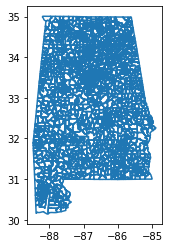

In [4]:
vest_al_16.boundary.plot()

In [5]:
vest_al_16.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST16', 'GEOID16', 'NAME16', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOWRI', 'G16USSRSHE',
       'G16USSDCRU', 'G16USSOWRI', 'G16SSCRBOL', 'G16SSCOWRI', 'G16SSCRWIS',
       'G16SSCOWR2', 'G16SSCRPAR', 'G16SSCOWR3', 'G16PSCRCAV', 'G16PSCOWRI',
       'geometry'],
      dtype='object')

In [6]:
vest_al_16.head(5)

,STATEFP20,COUNTYFP20,VTDST16,GEOID16,NAME16,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOWRI,...,G16USSOWRI,G16SSCRBOL,G16SSCOWRI,G16SSCRWIS,G16SSCOWR2,G16SSCRPAR,G16SSCOWR3,G16PSCRCAV,G16PSCOWRI,geometry
0,01,013,000100,01013000100,Monterey School House,22,33,2,0,0,...,0,22,1,22,1,22,1,21,1,"POLYGON ((-86.90894 31.96167, -86.90632 31.961..."
1,01,013,000181,01013000181,Bolling,83,40,2,0,0,...,0,87,0,85,0,87,0,87,1,"POLYGON ((-86.71867 31.73289, -86.71864 31.732..."
2,01,053,000080,01053000080,Rock Hill-Ridge VFD,227,72,3,2,3,...,1,216,1,216,1,213,1,208,2,"POLYGON ((-87.05166 31.11854, -87.04869 31.118..."
3,01,053,000120,01053000120,Damascus-Boykin School,169,132,1,0,0,...,0,138,4,137,3,136,2,140,2,"POLYGON ((-86.95858 31.16635, -86.95844 31.166..."
4,01,053,000100,01053000100,Bradley VFD,67,3,1,1,0,...,0,46,0,48,0,47,0,47,0,"POLYGON ((-86.82985 31.02083, -86.82983 31.020..."


### Create a FIPs dictionary

In [7]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Alabama"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
al_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Election Results

### Load, Pivot, Clean Election Results

There is a directory of excel files that need to be pivoted of election results. 

First, confirm that the file structure is the same for all of the files:

In [8]:
files = os.listdir('./raw-from-source/SOS/2016-General-PrecinctLevel/')

In [9]:
temp = pd.read_excel('./raw-from-source/SOS/2016-General-PrecinctLevel/2016-General-Autauga.xls')
columns = temp.columns
print(columns)

flag = True
for file in files: 
    temp = pd.read_excel('./raw-from-source/SOS/2016-General-PrecinctLevel/' + file)
    if columns.to_list()[:3] != temp.columns.to_list()[:3]:
        print(columns)
        print(temp.columns)
        flag = False
if flag:
    print('All files have the same first 3 columns: ', columns.to_list()[:3])

Index(['Contest Title', 'Party', 'Candidate', '10 JONES COMMUNITY CTR',
       '100 TRINITY METHODIST', '110 CENTRAL AL ELECTRIC',
       '140 AUTAUGAVILLE VFD', '150 PRATTMONT BAPTIST CH',
       '160 DOSTER COMMUNITY CTR', '170 CAMELLIA BAPTIST CH',
       '180 OLD KINGSTON VFD', '20 HERITAGE BAPTIST', '220 UPPER KINGSTON',
       '30 BILLINGSLEY GOVT_ BLDG', '40 E_MEMORIAL CHRISTIAN',
       '50 WHITE CITY VFD', '60 MARBURY MIDDLE SCH',
       '70 PINE LEVEL CULTURAL CT', '80 INDEPENDENCE VFD', '90 BOOTH VFD',
       'ABSENTEE', 'PROVISIONAL'],
      dtype='object')
All files have the same first 3 columns:  ['Contest Title', 'Party', 'Candidate']


Next, go through and pivot each file, clean them, and concatenate. 

In [10]:
def pivot_clean_county_file(df, county_name): 
    """Given a dataframe, pivot the table, order and rename columns, and return the cleaned table that can be concatenated. """
    
    df_pivot = pd.pivot_table(df,values=[x for x in df.columns.to_list() if x not in ('Contest Title','Party','Candidate')],
                              columns=['Contest Title',"Candidate"],aggfunc=sum)
    df_pivot['county'] = county_name
    df_pivot.reset_index(inplace = True)
    df_pivot.columns = [(x.strip(), y.strip()) for x,y in df_pivot.columns.values]
    
    if county_name in ('Mobile'):
        cols_to_add = [('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 2', 'Write-In'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 1', 'Write-In'), ('PRESIDENT, PUBLIC SERVICE COMMISSION', 'Write-In'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 3', 'Write-In'), ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Write-In'),('UNITED STATES SENATOR', 'Write-In')]
        for x,y in cols_to_add:
            df_pivot[x,y] = 0
    
    if county_name in ('Greene'):
        ajsc = [('ASSOCIATE JUSTICE OF THE SUPREME COURT PLACE NO. 1', 'Michael F. "Mike" Bolin'),('ASSOCIATE JUSTICE OF THE SUPREME COURT PLACE NO. 1', 'Write-In'), 
                ('ASSOCIATE JUSTICE OF THE SUPREME COURT PLACE NO. 2', 'Kelli Wise'),('ASSOCIATE JUSTICE OF THE SUPREME COURT PLACE NO. 2', 'Write-In'), 
                ('ASSOCIATE JUSTICE OF THE SUPREME COURT PLACE NO. 3', 'Tom Parker'),('ASSOCIATE JUSTICE OF THE SUPREME COURT PLACE NO. 3', 'Write-In')]
    else:
        ajsc = [('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 1','Michael F. "Mike" Bolin'),('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 1','Write-In'),
                ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 2','Kelli Wise'),('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 2','Write-In'),
                ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 3','Tom Parker'),('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 3','Write-In')]
    
    clean_df = df_pivot[[('index',''),('county',''),
                        ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES','Donald J. Trump'),('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES','Hillary Rodham Clinton'),('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES','Gary Johnson'),('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES','Jill Stein'),('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES','Write-In'),
                        ('UNITED STATES SENATOR', 'Richard C. Shelby'), ('UNITED STATES SENATOR', 'Ron Crumpton'), ('UNITED STATES SENATOR', 'Write-In')]
                        + ajsc + 
                        [('PRESIDENT, PUBLIC SERVICE COMMISSION','Twinkle Andress Cavanaugh'),('PRESIDENT, PUBLIC SERVICE COMMISSION','Write-In')]]
    
    clean_df.columns = ['precinct','county','G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOWRI', 'G16USSRSHE',
       'G16USSDCRU', 'G16USSOWRI', 'G16SSCRBOL', 'G16SSCOWRI', 'G16SSCRWIS',
       'G16SSCOWR2', 'G16SSCRPAR', 'G16SSCOWR3', 'G16PSCRCAV', 'G16PSCOWRI']
    
    return clean_df

# [('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 2', 'Write-In'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 1', 'Write-In'), ('PRESIDENT, PUBLIC SERVICE COMMISSION', 'Write-In'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 3', 'Write-In'), ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Write-In')]

In [11]:
flag = 0
for file in files: 
    temp = pd.read_excel('./raw-from-source/SOS/2016-General-PrecinctLevel/' + file)
#     print(file.split('-')[2][:-4])
    clean_df = pivot_clean_county_file(temp, file.split('-')[2][:-4])
    if flag == 0:
        results_2016 = clean_df
        flag = 1
    else:
        results_2016 = pd.concat([results_2016, clean_df])

Add county fips to election results file

In [12]:
# Change column names to match the county fips dict
results_2016.loc[results_2016['county'] == 'StClair', 'county'] = 'St Clair'
results_2016.loc[results_2016['county'] == 'DeKalb', 'county'] = 'De Kalb'

#Map to the correct FIP
results_2016["county_fips"]=results_2016["county"].map(al_fips_dict).fillna(results_2016["county"])

#Print out the FIPS to make sure they all are in the correct format
results_2016["county_fips"].unique()

array(['133', '051', '055', '117', '011', '109', '097', '033', '077',
       '021', '035', '037', '105', '023', '027', '053', '089', '087',
       '129', '039', '115', '111', '017', '047', '057', '025', '123',
       '083', '005', '061', '003', '081', '113', '019', '103', '041',
       '029', '067', '131', '107', '073', '013', '001', '069', '125',
       '009', '031', '065', '043', '045', '119', '085', '079', '007',
       '015', '063', '091', '093', '059', '075', '049', '121', '127',
       '095', '099', '071', '101'], dtype=object)

In [13]:
results_2016.shape

(2341, 19)

In [14]:
vest_al_16.shape

(2000, 22)

## Compare Election Results Totals

### Compare Total Votes

In [15]:
races = [x for x in vest_al_16.columns if 'G16' in x]
races

['G16PRERTRU',
 'G16PREDCLI',
 'G16PRELJOH',
 'G16PREGSTE',
 'G16PREOWRI',
 'G16USSRSHE',
 'G16USSDCRU',
 'G16USSOWRI',
 'G16SSCRBOL',
 'G16SSCOWRI',
 'G16SSCRWIS',
 'G16SSCOWR2',
 'G16SSCRPAR',
 'G16SSCOWR3',
 'G16PSCRCAV',
 'G16PSCOWRI']

In [16]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_al_16[i])
    sum_var_2 += np.sum(results_2016[i])
print(sum_var_1)
print(sum_var_2)

9876744
9844122.0


### Compare County Totals

The `compare()` method shows rows where the values are different, by default. So displaying nothing here is good, all county race totals are equal. 

In [17]:
count = 0
votes_to_add = pd.DataFrame(columns=["county","candidate","value"])
diff_counties=[]
for i in races:
    diff = results_2016.groupby(['county_fips']).sum()[i]-vest_al_16.groupby(['COUNTYFP20']).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
        for index,row in diff[diff != 0].iteritems():
            votes_to_add.loc[count] = [index,i,-int(row)]
            count+=1
print("All other races in all counties are equal")

print(diff_counties)

G16PRERTRU
009     -51.0
011      -1.0
047      -5.0
053     347.0
065      -1.0
071     -29.0
073    -270.0
075      -4.0
079    -101.0
093      -1.0
097   -1114.0
107      -2.0
111      -8.0
115     -72.0
117    -174.0
129     -11.0
131      -5.0
G16PREDCLI
009      -6.0
047     -10.0
053      93.0
063      -1.0
065      -3.0
071     -10.0
073    -489.0
075      -1.0
079     -16.0
097   -1185.0
111      -1.0
113      -2.0
115     -39.0
117     -50.0
129      -8.0
131     -10.0
G16PRELJOH
009    -1.0
053     7.0
071    -4.0
073   -32.0
079    -1.0
097   -59.0
115    -6.0
117    -9.0
G16PREGSTE
053     1.0
073   -14.0
097   -14.0
117    -1.0
G16PREOWRI
053       4.0
071      -2.0
073     -25.0
097   -1353.0
113      -2.0
115      -2.0
117      -2.0
G16USSRSHE
009     -52.0
011      -1.0
047      -7.0
053     640.0
065      -2.0
071     -26.0
073    -334.0
075      -5.0
079     -99.0
093      -1.0
097   -1163.0
107      -2.0
111      -7.0
113      -2.0
115     -82.0
117    -181.0
129   

In [18]:
al_fips_dict = dict(zip(fips_file["FIPS County"],fips_file["County Name"]))

for county in diff_counties:
    print(al_fips_dict[county])


Blount
Bullock
Dallas
Escambia
Hale
Jackson
Jefferson
Lamar
Lawrence
Marion
Mobile
Pickens
Randolph
St Clair
Shelby
Washington
Wilcox
Greene
Russell


In [19]:
#Checking to see if we are adding negative votes, we are, so we need to be careful
print(min(votes_to_add["value"]))

votes_to_add_pivot = pd.pivot_table(votes_to_add,index=["county"],values="value",columns=["candidate"],aggfunc=sum)
votes_to_add_pivot.reset_index(inplace=True,drop=False)
votes_to_add_pivot = votes_to_add_pivot.fillna(0)

-640


### Escambia county has negative values

- Did VEST just subtract these?

In [20]:
print(votes_to_add_pivot)

candidate county  G16PREDCLI  G16PREGSTE  G16PRELJOH  G16PREOWRI  G16PRERTRU  \
0            009         6.0         0.0         1.0         0.0        51.0   
1            011         0.0         0.0         0.0         0.0         1.0   
2            047        10.0         0.0         0.0         0.0         5.0   
3            053       -93.0        -1.0        -7.0        -4.0      -347.0   
4            063         1.0         0.0         0.0         0.0         0.0   
5            065         3.0         0.0         0.0         0.0         1.0   
6            071        10.0         0.0         4.0         2.0        29.0   
7            073       489.0        14.0        32.0        25.0       270.0   
8            075         1.0         0.0         0.0         0.0         4.0   
9            079        16.0         0.0         1.0         0.0       101.0   
10           093         0.0         0.0         0.0         0.0         1.0   
11           097      1185.0        14.0

VEST documentation says: 
> Incorrect or incomplete data was replaced using the county canvass reports for the following counties: Blount, Bullock, Dallas, Escambia, Greene, Hale, Jackson, Jefferson, Lamar, Lawrence, Marion, Pickens, Randolph, Russell, St. Clair, Shelby, Washington, Wilcox.


### Compare Race Totals

In [21]:
for race in races:
    diff_val = sum(vest_al_16[race])-sum(results_2016[race])
    if diff_val != 0:
        print(race+": "+str(diff_val), "\tVEST sum: ", sum(vest_al_16[race]), "\tRDH sum: ", sum(results_2016[race]))
    else:
        print(race+": EQUAL")

G16PRERTRU: 1502.0 	VEST sum:  1318629 	RDH sum:  1317127.0
G16PREDCLI: 1738.0 	VEST sum:  729607 	RDH sum:  727869.0
G16PRELJOH: 105.0 	VEST sum:  44478 	RDH sum:  44373.0
G16PREGSTE: 28.0 	VEST sum:  9395 	RDH sum:  9367.0
G16PREOWRI: 1382.0 	VEST sum:  21715 	RDH sum:  20333.0
G16USSRSHE: 1339.0 	VEST sum:  1335470 	RDH sum:  1334131.0
G16USSDCRU: 1736.0 	VEST sum:  748787 	RDH sum:  747051.0
G16USSOWRI: 378.0 	VEST sum:  3632 	RDH sum:  3254.0
G16SSCRBOL: 1890.0 	VEST sum:  1388763 	RDH sum:  1386873.0
G16SSCOWRI: 4287.0 	VEST sum:  36370 	RDH sum:  32083.0
G16SSCRWIS: 1891.0 	VEST sum:  1382078 	RDH sum:  1380187.0
G16SSCOWR2: 4123.0 	VEST sum:  34265 	RDH sum:  30142.0
G16SSCRPAR: 1869.0 	VEST sum:  1375880 	RDH sum:  1374011.0
G16SSCOWR3: 4220.0 	VEST sum:  34967 	RDH sum:  30747.0
G16PSCRCAV: 1867.0 	VEST sum:  1373295 	RDH sum:  1371428.0
G16PSCOWRI: 4267.0 	VEST sum:  39413 	RDH sum:  35146.0


### Compare Precinct-by-Precinct

In [22]:
results_2016["unique_ID"] = results_2016["county_fips"] +"-"+results_2016["precinct"]

vest_al_16["unique_ID"] = vest_al_16["COUNTYFP20"] +"-"+vest_al_16["NAME16"].str.upper()

pro_ab_list = list(results_2016[(results_2016["precinct"].str.contains("ABSENTEE")) |(results_2016["precinct"].str.contains("PROVISIONAL"))| (results_2016["unique_ID"].isin(["031-PROVISONAL","039-PROVSIONAL","101-ABSEN","101-PROVI"]))]["unique_ID"])

In [23]:
print(pro_ab_list)

non_prov_absentee = results_2016[~results_2016["unique_ID"].isin(pro_ab_list)]
prov_absentee = results_2016[results_2016["unique_ID"].isin(pro_ab_list)]

['133-ABSENTEE', '133-PROVISIONAL', '051-ABSENTEE 1-40', '051-ABSENTEE 41-54', '051-PROVISIONAL 1-40', '051-PROVISIONAL 41-54', '055-ABSENTEE', '055-PROVISIONAL', '117-ABSENTEE', '117-PROVISIONAL', '011-ABSENTEE', '011-PROVISIONAL', '109-ABSENTEE', '109-PROVISIONAL', '097-ABSENTEE #1', '097-ABSENTEE #2', '097-PROVISIONAL #1', '097-PROVISIONAL #2', '033-ABSENTEE', '033-PROVISIONAL', '077-ABSENTEE', '077-PROVISIONAL', '021-ABSENTEE', '021-PROVISIONAL', '035-ABSENTEE', '035-PROVISIONAL', '037-ABSENTEE', '037-PROVISIONAL', '105-ABSENTEE', '105-PROVISIONAL', '023-ABSENTEE', '023-PROVISIONAL', '027-ABSENTEE', '027-PROVISIONAL', '053-ABSENTEE', '053-PROVISIONAL', '089-ABSENTEE', '089-PROVISIONAL', '087-ABSENTEE', '087-PROVISIONAL', '129-ABSENTEE', '129-PROVISIONAL', '039-ABSENTEE', '039-PROVSIONAL', '115-ABSENTEE', '115-PROVISIONAL', '111-ABSENTEE', '111-PROVISIONAL', '017-ABSENTEE', '017-PROVISIONAL', '047-ABSENTEE', '047-PROVISIONAL', '057-ABSENTEE', '057-PROVISIONAL', '025-ABSENTEE', '025-

In [24]:
def vote_merger (merge_list,new_name):
    global non_prov_absentee
    races = [x for x in vest_al_16.columns if 'G16' in x]

    #Add in the other votes
    
    for i in range(1,len(merge_list)):
        for race in races:
            non_prov_absentee.loc[non_prov_absentee["unique_ID"]==merge_list[0],race]+=int(non_prov_absentee.loc[non_prov_absentee["unique_ID"]==merge_list[i],race])
    
    #Update the unique ID
    non_prov_absentee.loc[non_prov_absentee["unique_ID"]==merge_list[0],"unique_ID"]=new_name
    
    #Remove the ones that aren't needed
    non_prov_absentee = non_prov_absentee[~non_prov_absentee["unique_ID"].isin(merge_list[1:])]
    
    non_prov_absentee.reset_index(inplace=True,drop=True)

In [25]:
non_prov_absentee["ID_len"] = non_prov_absentee["unique_ID"].apply(lambda x: x[0:len(x)-3] if (x[0:3]=="097" or x[0:3]=="101") else x)

#Load in the nationwide FIPS file
names_97 = pd.read_csv("./97_101_names.csv")

#Create the dictionary
names_97_dict = dict(zip(names_97["og_names"],names_97["new_names"]))


names_097_101 = list(non_prov_absentee[(non_prov_absentee["unique_ID"].str[0:3]=="097")|(non_prov_absentee["unique_ID"].str[0:3]=="101")]["ID_len"].unique())

#Make a dictionary that maps from these names to the shortened 097

for i in names_097_101:
    merge_list = list(non_prov_absentee[non_prov_absentee["unique_ID"].str.contains(i)]["unique_ID"])
    #Create a dictionary here
    new_name = names_97_dict[i]
    vote_merger(merge_list,new_name)

<ipython-input-25-e3b8cb53c00e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_prov_absentee["ID_len"] = non_prov_absentee["unique_ID"].apply(lambda x: x[0:len(x)-3] if (x[0:3]=="097" or x[0:3]=="101") else x)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py

In [26]:
vote_merger(["043-FAIRVIEW FIRE DEPT_ (A-K)","043-FAIRVIEW TOWN HALL (L-Z)"],"043-FAIRVIEW FD/TOWN HALL")
vote_merger(["049-FORT PAYNE SENIOR CITIZEN 1","049-FORT PAYNE SENIOR CITIZEN 2"],"049-FORT PAYNE SENIOR CTR")
vote_merger(["049-RAINSVILLE 1","049-RAINSVILLE 2"],"049-RAINSVILLE DEKALB SCHOOLS")
vote_merger(["049-WILLS VALLEY REC CENTER 1","049-WILLS VALLEY REC CENTER 2"],"049-WILLS VALLEY REC CENTER")
vote_merger(["049-VFW HALL LOBBY 1","049-VFW HALL LOBBY 2"],"049-VFW HALL")
vote_merger(["111-NATIONAL GUARD ARMORY #1","111-NATIONAL GUARD ARMORY #2","111-NATIONAL GUARD ARMORY #3"],"111-NATIONAL GUARD ARMORY")
vote_merger(["111-WEDOWEE CITY HALL #1","111-WEDOWEE CITY HALL #2"],"111-WEDOWEE CITY HALL")

In [27]:
attempt_one = pd.merge(non_prov_absentee,vest_al_16,on="unique_ID",how="outer",indicator=True)
print(attempt_one["_merge"].value_counts())



source_vest_id_changes = pd.read_csv("./source_vest_id_changes.csv")
source_vest_id_changes_dict = dict(zip(source_vest_id_changes["source_ID"],source_vest_id_changes["vest_ID"]))

vals_to_delete = []
print(len(source_vest_id_changes_dict))
for val in source_vest_id_changes_dict:
    if source_vest_id_changes_dict[val] not in list(vest_al_16["unique_ID"]):
        vals_to_delete.append(val)

for val in vals_to_delete:
    del source_vest_id_changes_dict[val]

print(len(source_vest_id_changes_dict))

attempt_one = pd.merge(non_prov_absentee,vest_al_16,on="unique_ID",how="outer",indicator=True)
print(attempt_one["_merge"].value_counts())

non_prov_absentee["unique_ID"] = non_prov_absentee["unique_ID"].map(source_vest_id_changes_dict).fillna(non_prov_absentee["unique_ID"])

attempt_one = pd.merge(non_prov_absentee,vest_al_16,on="unique_ID",how="outer",indicator=True)
print(attempt_one["_merge"].value_counts())

elections_only = attempt_one[attempt_one["_merge"]=="left_only"]
elections_only.to_csv("./only_elections.csv")

vest_only = attempt_one[attempt_one["_merge"]=="right_only"]
vest_only.to_csv("./only_vest.csv")

left_only     1248
right_only    1247
both           753
Name: _merge, dtype: int64
1879
1793
left_only     1248
right_only    1247
both           753
Name: _merge, dtype: int64
both          1987
right_only      18
left_only       14
Name: _merge, dtype: int64


# Precinct Shapefile

## Documentation

> Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program final release, except the following counties use shapefiles sourced from the respective county governments instead: Baldwin, Blount, Calhoun, Cullman, DeKalb, Franklin, Jefferson, Lee, Limestone, Madison, Marengo, Marshall, Mobile, Morgan, St. Clair, Shelby, Talladega, Tuscaloosa.

Note: There are four separate categories:
1. Counties where VEST used data from the U.S. Census Bureau's 2020 Redistricting Data Program final release
2. Counties where VEST sourced shapefiles from the respective county government and we were able to find a shapefile
3. Counties where VEST sourced shapefiles from the respective county government and we were able to find some sort of map
4. Counties where VEST sourced shapefiles from the respective county government and we were unable to find any information

For validation purposes, we can group together (1) and (2), work on (3) separately, and there won't be anything to do with (4).

### Work to split up shapefiles / election results into these categories

In [28]:
al_fips_dict_mod = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

alt_source = ["Baldwin", "Blount", "Calhoun", "Cullman", "De Kalb", 
              "Franklin", "Jefferson", "Lee", "Limestone", "Madison", 
              "Marengo", "Marshall", "Mobile", "Morgan", "St Clair", "Shelby", "Talladega", "Tuscaloosa"]


diff_fips_list = []
for val in alt_source:
    diff_fips_list.append(al_fips_dict_mod[val])

## 1. Counties w/ Census Source

Link to the 2020 TIGER/Line files for AL, where we can download the VTD file, assuming the file did not change: 
https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/01_ALABAMA/01/

In [37]:
tiger_vtd = gp.read_file('./raw-from-source/Census/tl_2020_01_vtd20/tl_2020_01_vtd20.shp')

census_source = tiger_vtd[~(tiger_vtd["COUNTYFP20"].isin(diff_fips_list))]

results_2016_census = non_prov_absentee[~(non_prov_absentee["county_fips"].isin(diff_fips_list))]


## 2. Precinct Boundaries from County - Shapefile Available (0)
No counties fall into this category

## Attempt to join election results to precinct boundaries where shapefile exists

In [39]:
#print(results_2016_census)
#print(census_source.columns)

#census_source["unique_ID"] = census_source["COUNTYFP20"]+"-"+census_source["NAME20"].str.upper()
census_source["unique_ID"] = census_source["COUNTYFP20"]+"-"+census_source["NAMELSAD20"].str.upper()

join_attempt_one = pd.merge(results_2016_census,census_source,on="unique_ID",how="outer",indicator=True)
print(join_attempt_one["_merge"].value_counts())

shapes_only = join_attempt_one[join_attempt_one["_merge"]=="left_only"]
shapes_only.to_csv("./only_shapes.csv")

elections_only = join_attempt_one[join_attempt_one["_merge"]=="right_only"]
elections_only.to_csv("./only_elections.csv")

both          731
left_only     409
right_only    347
Name: _merge, dtype: int64


In [31]:
def break;

SyntaxError: invalid syntax (<ipython-input-31-f888da8258d8>, line 1)

In [ ]:
#Plot what they look like on top of one another, looks similar to what VEST has
ax = tiger_vtd.boundary.plot(figsize=(10,10),color="green")
vest_al_16.boundary.plot(figsize=(10,10),ax=ax,color="red")

## 3. Precinct Boundaries from County - Non-Shapefile Map Available (1)
10 counties fall into this category:

1. Baldwin County  
Link: https://baldwincountyal.gov/government/probate-office/elections/district-maps-voting-precincts  
Note: they have a GIS department but only PDF map available on the website at that link.  
2. Calhoun County  
Link: https://www.calhouncounty.org/forms/Commission_Districts_Voting.pdf  
Note: only finding a PDF map on their website.  
3. Limestone County  
Link: https://www.votelimestone.com/related-links/limestone-county-beat-map-with-polling-locations/  
Note: only finding a PDF map on their website.  
4. Madison County  
Link: https://www.madisoncountyvotes.com/voter-resources/polling-locations/  
Note: their interactive precinct map only shows the polling locations, but not precinct boundaries.  
5. Mobile County  
Link: https://www.mobilecountyal.gov/government/departments/administration/gis-mapping/election-maps/  
Note: only finding a PDF map on their website. You can request GIS maps by mail request form.  
6. Morgan County  
Link: https://www.morgancountyelections.com/election-information/precinct-maps/  
Note: there is an interactive arcgis precinct map, but there is no download option. Emailed Kate Terry, the Chief Clerk at kterry@morgancounty-al.gov.  
7. St. Clair County  
Link: https://stclair.maps.arcgis.com/apps/webappviewer/index.html?id=63f82a53398c49d38bf0e036e163e08a  
Note: there is an interactive argis precinct map, but there is no download option. Emailed gissupport@stclairco.com  
8. Shelby County  
Link: https://maps.shelbyal.com/html5/  
Note: there is an interactive arcgis precinct map, but there is no download option. Called the county IT Services (205-670-6981), and told to call back and ask for Victoria at 1pm (6/4/2021).  
9. Talladega County  
Link: https://www.talladegacountyal.org/departments/voter_registration/county_district_maps.php  
Note: only finding a PDF map from 2013. Unlikely that they have a shapefile because the map looks like a scan of a physical copy.  
10. Cullman County  
Note: not finding a precinct map on their county website, there is a jpg map in the Cullman Times from 2014 at this   link: https://www.cullmantimes.com/cullman-county-voting-precincts-map/image_0269f200-6231-11e4-9024-af8efe886238.html

### Baldwin

['Marlow/Fish River VFD', 'Spanish Fort New Life Assembly', 'Ellisville Comm Ctr', 'Loxley Civic Ctr', 'Stapleton VFD', 'Fairhope 3 Circle Church', 'Spanish Fort Church of Christ', 'Rosinton UMC', 'Belforest Comm Ctr', 'Silverhill Comm Ctr', 'Fairhope Avenue Baptist', 'Bethel Baptist', 'Daphne High', 'Elberta Civic Ctr', 'Graham Creek Interpretive Ctr', 'Douglasville Boykin Ctr', 'Stockton Civic Bldg', 'Rabun VFD', 'Pine Grove VFD Station #1', 'White House Fork VFD', 'PZK Hall', 'Bay Minette Civic Ctr', 'Gulf Shores Cultural Ctr', 'Lillian Community Club', 'Peridido Beach VFD', 'Josephine VFD', 'Daphne Civic Ctr', 'Spanish Fort Comm Ctr', 'Bromley-Crossroads VFD', 'Crossroads Durant Chapel Baptist', 'Old Vaughn School', 'Tensaw VFD', 'Little River VFD', 'Lottie VFD', 'Fort Morgan VFD #1', 'Fairhope Civic Ctr', 'Pt Clear St Francis Pt Anglican', 'Mars Hill Church', 'Barnwell VFD', 'Magnolia Springs Wesleyan', "Bon Secour Morgan's Chapel UMC", 'Orange Beach Comm Ctr', 'Gulf Shores Meyer 

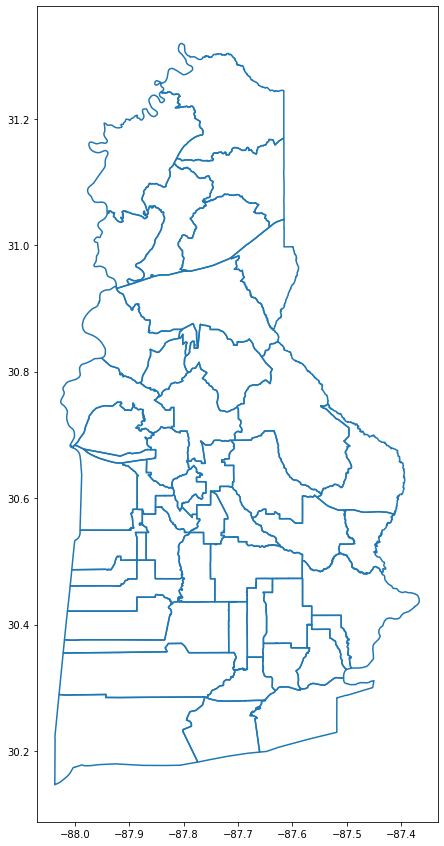

In [74]:
vest_al_16[vest_al_16["COUNTYFP20"]=="003"].boundary.plot(figsize=(15,15))
print(list(vest_al_16[vest_al_16["COUNTYFP20"]=="003"]["NAME20"]))

In [80]:

IFrame("./raw-from-source/County_Shapefiles/Baldwin/2021_Baldwin_Precincts.pdf", width=900, height=900)

In [79]:
IFrame("./raw-from-source/County_Shapefiles/Baldwin/Voting-Precincts-and-Voting-Places-in-Baldwin-County-AL-(PUBLIC)---Revised-July-20-2020908144dd-8fd7-4d13-acd2-d6032a3905ec.pdf", width=900, height=900)

### Calhoun

In [ ]:
vest_al_16[vest_al_16["COUNTYFP20"]=="015"].boundary.plot(figsize=(15,15))
print(list(vest_al_16[vest_al_16["COUNTYFP20"]=="015"]["NAME20"]))

In [81]:
IFrame("./raw-from-source/County_Shapefiles/Calhoun/Commission_Districts_Voting.pdf", width=900, height=900)

### Limestone

In [ ]:
vest_al_16[vest_al_16["COUNTYFP20"]=="083"].boundary.plot(figsize=(15,15))
print(list(vest_al_16[vest_al_16["COUNTYFP20"]=="083"]["NAME20"]))

In [ ]:
IFrame("./raw-from-source/County_Shapefiles/Limestone/2020-Limestone-County-Beat-Map-with-Polling-Locations.pdf", width=900, height=900)

### Madison

In [ ]:
vest_al_16[vest_al_16["COUNTYFP20"]=="089"].boundary.plot(figsize=(15,15))
print(list(vest_al_16[vest_al_16["COUNTYFP20"]=="089"]["NAME20"]))

In [82]:
IFrame("./raw-from-source/County_Shapefiles/Madison/2020-Polling-Loations-as-of-7-14-2020.pdf", width=900, height=900)

### Mobile

In [ ]:
vest_al_16[vest_al_16["COUNTYFP20"]=="097"].boundary.plot(figsize=(15,15))
print(list(vest_al_16[vest_al_16["COUNTYFP20"]=="097"]["NAME20"]))

In [ ]:
IFrame("./raw-from-source/County_Shapefiles/Mobile/Precincts2020.pdf", width=900, height=900)

### Morgan

In [ ]:
vest_al_16[vest_al_16["COUNTYFP20"]=="103"].boundary.plot(figsize=(15,15))
print(list(vest_al_16[vest_al_16["COUNTYFP20"]=="103"]["NAME20"]))

In [83]:
IFrame("./raw-from-source/County_Shapefiles/Morgan/Map_Screenshot.png", width=900, height=900)

### St. Clair

In [ ]:
vest_al_16[vest_al_16["COUNTYFP20"]=="115"].boundary.plot(figsize=(15,15))
print(list(vest_al_16[vest_al_16["COUNTYFP20"]=="115"]["NAME20"]))

In [84]:
IFrame("./raw-from-source/County_Shapefiles/St_Clair/Map_Screenshot.png", width=900, height=900)

### Shelby

In [ ]:
vest_al_16[vest_al_16["COUNTYFP20"]=="117"].boundary.plot(figsize=(15,15))
print(list(vest_al_16[vest_al_16["COUNTYFP20"]=="117"]["NAME20"]))

In [85]:
IFrame("./raw-from-source/County_Shapefiles/Shelby/Map_Screenshot.png", width=900, height=900)

### Talladega

In [ ]:
vest_al_16[vest_al_16["COUNTYFP20"]=="121"].boundary.plot(figsize=(15,15))
print(list(vest_al_16[vest_al_16["COUNTYFP20"]=="121"]["NAME20"]))

In [86]:
IFrame("./raw-from-source/County_Shapefiles/Talladega/voting precints map.pdf", width=900, height=900)

### Cullman

['Vinemont Comm Ctr', 'Arkadelphia FD', 'Providence FD', 'Bethsadia FD', 'Gold Ridge Comm Ctr', 'Berlin Comm Ctr', 'Welti Mt Zion Church', 'Joppa VFD', 'Friendship Church', 'Crane Hill FD', 'Moody Town Union Hill Church', 'Dodge City Comm Ctr', 'Valley Grove Comm Ctr', 'Simcoe Comm Ctr', 'Hanceville City Hall', 'Trimble Fire Dept', 'Colony Education Complex', 'Baileyton Senior Ctr', 'Brushy Pond Comm Ctr', 'Bremen FD', 'Garden City Town Hall', 'West Point Comm Ctr', 'Stouts Mountain Church', 'Hanceville Civic Ctr', 'Baldwin Comm Ctr', 'Grandview Comm Ctr', 'Johnson Crossing VFD', 'Beat 8 Comm Ctr', 'Brooklyn Comm Ctr', 'Center Hill Comm Ctr', 'Walter Comm Ctr', 'Holly Pond FD', 'Cullman Co Health Dept', 'Good Hope City Hall', 'Donald E Green Senior Ctr', 'Cullman Co Office Bldg', 'Kelley Comm Ctr', 'East Point Comm Ctr', 'Bolte White Grove Church', 'Cullman City Hall', 'Battleground FD', 'Bethel Comm Ctr', 'Jones Chapel FD', 'Logan FD', 'New Canaan Senior Ctr', 'Fairview FD/Town Hall',

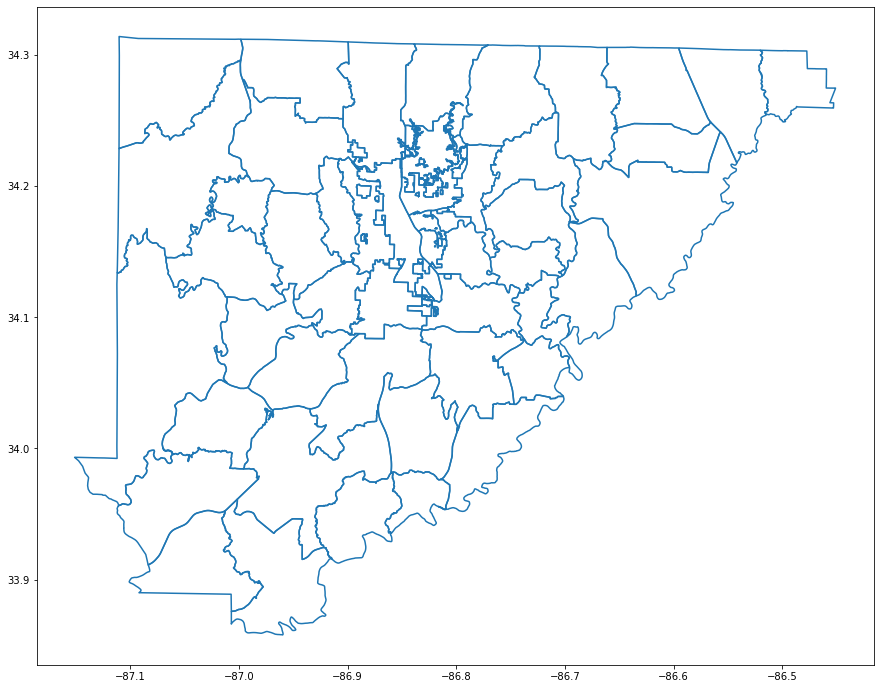

In [88]:
vest_al_16[vest_al_16["COUNTYFP20"]=="043"].boundary.plot(figsize=(15,15))
print(list(vest_al_16[vest_al_16["COUNTYFP20"]=="043"]["NAME20"]))

In [87]:
IFrame("./raw-from-source/County_Shapefiles/Cullman/54558b3036051.image.jpg", width=900, height=900)

## 4. Precinct Boundaries from County - No Map Available (8)
8 counties fall into this category:
1. Dekalb
2. Franklin
3. Jefferson
4. Lee
5. Marengo
6. Marshall
7. Tuscaloosa
8. Blount

Note: Precinct changes over time are listed for Jefferson County (https://jeffcoprobatecourt.com/elections/voting-precinct-changes/) and polling locations are listed for Marshall and Tuscaloosa Counties.

In [ ]:
al_fips_dict_mod = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

alt_source = [ "De Kalb", "Franklin", "Jefferson", "Lee", "Marengo", "Marshall", "Tuscaloosa"]

for county in alt_source:
    plt = vest_al_16[vest_al_16["COUNTYFP20"]==al_fips_dict_mod[county]].plot(figsize=(20,20),column="NAME16",legend=True)
    plt.set_title(county)

In [ ]:
for county in alt_source:
    plt = vest_al_16[vest_al_16["COUNTYFP20"]==al_fips_dict_mod[county]].boundary.plot(figsize=(10,10))
    plt.set_title(county)

# Shapefile Validation

In [ ]:
shapefile_election = attempt_two[attempt_two["_merge"]=="both"]
attempt_two = pd.merge(tiger_vtd,non_prov_absentee,indicator=True,how="outer",on="unique_ID")
print(attempt_two["_merge"].value_counts())
final_merge = pd.merge(vest_al_16,shapefile_election,indicator="final_merge",how="outer",on="unique_ID")

In [ ]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x",crs=vest_al_20.crs)
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y",crs=vest_al_20.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

In [ ]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > .1):
        count += 1
        name = source_geoms.iat[i,2]
        
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [ ]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")